In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER




In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor, start=160, num_days=112):
    t_subset = tensor[:, :, start:start+num_days, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, num_days*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    print(len(all_indices))
    t_subset = t_subset[all_indices, :, :, :].reshape(len(all_indices), 7, num_days*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

52


(52, 7, 2688)

In [6]:
appliance_num=APPLIANCES_ORDER[:].index("fridge")
d = pd.DataFrame(t_all[:, appliance_num, :].reshape(52*112, 24))

In [7]:
num_days=112
d = pd.DataFrame(t_all[:30, 6, :].reshape(30*num_days, 24))
(d>1000).sum().sum()/(d.size)

0.0030629960317460317

In [8]:
pd.DataFrame(t_all[3, appliance_num, :].reshape(24,112)).T.mean()

0      99.509077
1     107.827976
2     108.185863
3     109.797917
4     110.605655
5     114.803422
6     116.526339
7     116.429465
8     119.393006
9     127.677827
10    120.741220
11     93.902828
12     97.657292
13     91.656994
14     85.258482
15     93.678125
16     89.674404
17     89.500893
18     97.718304
19    102.186459
20     91.381101
21     97.462946
22     97.643899
23     95.700893
dtype: float64

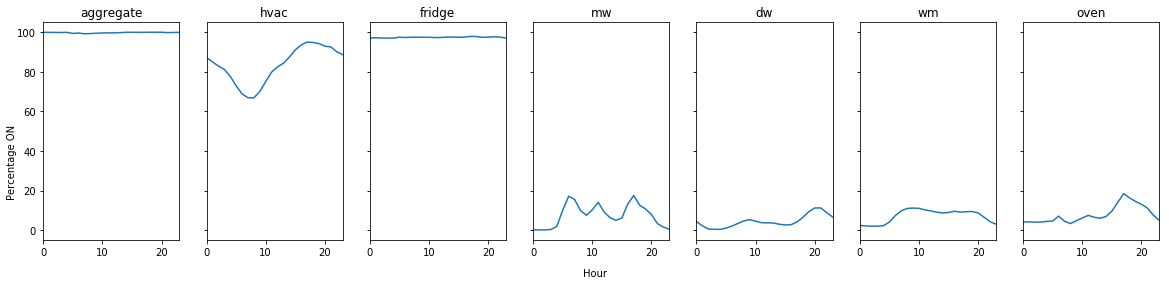

In [9]:
fig, ax = plt.subplots(ncols=7, sharey=True, figsize=(20, 4))

for appliance_num, appliance in enumerate(APPLIANCES_ORDER):
    d = pd.DataFrame(t_all[:, appliance_num, :].reshape(52*112, 24))
    pd.Series((d>10).sum()*100/len(d)).plot(title=appliance, ax=ax[appliance_num])
fig.text(0.5, 0,"Hour")
fig.text(0.10, 0.5,"Percentage ON", rotation='vertical')

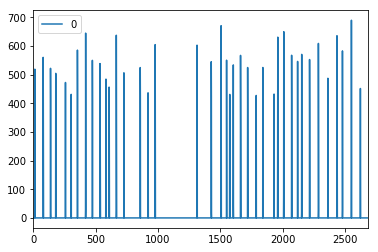

In [10]:
pd.DataFrame(t_all[30, 4, :]).plot()

In [11]:
(pd.DataFrame(t_all[:,3,:])>20).astype('int').sum()

0        0
1        0
2        0
3        0
4        2
5        5
6        5
7        4
8        1
9        1
10       5
11      10
12       4
13       1
14       0
15       2
16       2
17      11
18       6
19       1
20       3
21       0
22       2
23       1
24       0
25       0
26       0
27       0
28       1
29       7
        ..
2658     8
2659     2
2660     2
2661     1
2662     1
2663     0
2664     0
2665     0
2666     0
2667     0
2668     0
2669     4
2670     9
2671     7
2672     3
2673     2
2674     4
2675     8
2676     3
2677     1
2678     1
2679     2
2680     7
2681    10
2682    10
2683     5
2684     4
2685     1
2686     0
2687     0
Length: 2688, dtype: int64

In [12]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [13]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [14]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [112]:
num_days = 112
n_train = 30
train_agg = t_all[:30, 0, :].reshape(30*num_days, 24)
train_appliance = {}
test_appliance = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    train_appliance[appliance] = t_all[:30, appliance_num+1, :].reshape(30*num_days, 24)
    test_appliance[appliance] = t_all[30:, appliance_num+1, :].reshape(22*num_days, 24)






test_hvac = t_all[30:, 1, :].reshape(22*num_days, 24)
test_fridge = t_all[30:, 2, :].reshape(22*num_days, 24)

test_mw = t_all[30:, 3, :].reshape(22*num_days, 24)



test_agg = t_all[30:, 0, :].reshape(22*num_days, 24)

In [113]:
train_hvac.shape

NameError: name 'train_hvac' is not defined

In [114]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
test_hvac_fridge = np.hstack([test_hvac, test_fridge])

NameError: name 'train_hvac' is not defined

In [156]:
pred_appliance = {}
num_iterations_dictionary = {'hvac':400,'fridge':400,'mw':250,'dw':250,'oven':250, 'wm':300}
for appliance in APPLIANCES_ORDER[1:]:
    print(appliance)
    print("*"*20)
    np.random.seed(0)
    from keras.layers.merge import Subtract, Minimum
    from keras import regularizers
    agg_input = keras.layers.Input(shape=[24],name='Aggregate')
    appliance_dense_1 = keras.layers.Dense(units=40,name='Appliance-layer-1',activation='relu')(agg_input)
    #appliance_bn = keras.layers.BatchNormalization()(appliance_dense_1)
    dropout = keras.layers.Dropout(rate=0.1,name='Droput-Appliance')(appliance_dense_1)




    out = keras.layers.Dense(units=24,name='Appliance-output',activation='relu')(dropout)
    out = Minimum(name='Clip-to-agg')([out, agg_input])


    model = keras.Model(agg_input, out)
    model.compile('adam','mean_absolute_error')
    model.fit(train_agg, train_appliance[appliance], epochs=num_iterations_dictionary[appliance], validation_split=0.1)
    pred_appliance[appliance] = model.predict(test_agg)



hvac
********************
Train on 3024 samples, validate on 336 samples
Epoch 1/400
3024/3024 [==============================] - 1s 411us/step - loss: 389.8327 - val_loss: 217.2751
Epoch 2/400
3024/3024 [==============================] - 0s 44us/step - loss: 144.0624 - val_loss: 147.9315
Epoch 3/400
3024/3024 [==============================] - 0s 46us/step - loss: 130.1580 - val_loss: 147.5591
Epoch 4/400
3024/3024 [==============================] - 0s 44us/step - loss: 129.5078 - val_loss: 147.4047
Epoch 5/400
3024/3024 [==============================] - 0s 43us/step - loss: 129.4224 - val_loss: 147.2864
Epoch 6/400
3024/3024 [==============================] - 0s 49us/step - loss: 129.4555 - val_loss: 147.1929
Epoch 7/400
3024/3024 [==============================] - 0s 45us/step - loss: 129.3131 - val_loss: 147.1357
Epoch 8/400
3024/3024 [==============================] - 0s 44us/step - loss: 129.3007 - val_loss: 147.1504
Epoch 9/400
3024/3024 [==============================] - 0s 75

Epoch 150/400
3024/3024 [==============================] - 0s 51us/step - loss: 116.5373 - val_loss: 137.7956
Epoch 151/400
3024/3024 [==============================] - 0s 46us/step - loss: 116.4493 - val_loss: 137.0829
Epoch 152/400
3024/3024 [==============================] - 0s 44us/step - loss: 116.3497 - val_loss: 138.9972
Epoch 153/400
3024/3024 [==============================] - 0s 45us/step - loss: 116.9251 - val_loss: 137.5043
Epoch 154/400
3024/3024 [==============================] - 0s 48us/step - loss: 116.1950 - val_loss: 137.3617
Epoch 155/400
3024/3024 [==============================] - 0s 49us/step - loss: 115.9046 - val_loss: 137.9720
Epoch 156/400
3024/3024 [==============================] - 0s 46us/step - loss: 116.0016 - val_loss: 137.2115
Epoch 157/400
3024/3024 [==============================] - 0s 46us/step - loss: 115.9611 - val_loss: 137.1418
Epoch 158/400
3024/3024 [==============================] - 0s 46us/step - loss: 116.2370 - val_loss: 137.9172
Epoch 159/

3024/3024 [==============================] - 0s 46us/step - loss: 113.7683 - val_loss: 136.0418
Epoch 299/400
3024/3024 [==============================] - 0s 44us/step - loss: 113.1004 - val_loss: 135.8812
Epoch 300/400
3024/3024 [==============================] - 0s 45us/step - loss: 113.3891 - val_loss: 136.0120
Epoch 301/400
3024/3024 [==============================] - 0s 47us/step - loss: 113.3101 - val_loss: 135.6213
Epoch 302/400
3024/3024 [==============================] - 0s 45us/step - loss: 113.5654 - val_loss: 136.1679
Epoch 303/400
3024/3024 [==============================] - 0s 44us/step - loss: 113.0328 - val_loss: 135.9951
Epoch 304/400
3024/3024 [==============================] - 0s 42us/step - loss: 113.3232 - val_loss: 136.0009
Epoch 305/400
3024/3024 [==============================] - 0s 44us/step - loss: 113.1762 - val_loss: 135.8748
Epoch 306/400
3024/3024 [==============================] - 0s 45us/step - loss: 113.7444 - val_loss: 135.6003
Epoch 307/400
3024/3024 

3024/3024 [==============================] - 0s 35us/step - loss: 35.2119 - val_loss: 35.9621
Epoch 48/400
3024/3024 [==============================] - 0s 35us/step - loss: 34.5387 - val_loss: 34.2750
Epoch 49/400
3024/3024 [==============================] - 0s 35us/step - loss: 34.8856 - val_loss: 34.7468
Epoch 50/400
3024/3024 [==============================] - 0s 34us/step - loss: 34.6182 - val_loss: 34.9458
Epoch 51/400
3024/3024 [==============================] - 0s 35us/step - loss: 34.4269 - val_loss: 33.7897
Epoch 52/400
3024/3024 [==============================] - 0s 34us/step - loss: 34.7323 - val_loss: 33.6108
Epoch 53/400
3024/3024 [==============================] - 0s 35us/step - loss: 34.4953 - val_loss: 35.4869
Epoch 54/400
3024/3024 [==============================] - 0s 33us/step - loss: 34.2565 - val_loss: 36.5644
Epoch 55/400
3024/3024 [==============================] - 0s 33us/step - loss: 34.2670 - val_loss: 35.3438
Epoch 56/400
3024/3024 [==========================

Epoch 199/400
3024/3024 [==============================] - 0s 36us/step - loss: 31.2659 - val_loss: 36.4271
Epoch 200/400
3024/3024 [==============================] - 0s 34us/step - loss: 31.0931 - val_loss: 37.0187
Epoch 201/400
3024/3024 [==============================] - 0s 35us/step - loss: 31.0977 - val_loss: 36.1064
Epoch 202/400
3024/3024 [==============================] - 0s 35us/step - loss: 30.9812 - val_loss: 37.1316
Epoch 203/400
3024/3024 [==============================] - 0s 35us/step - loss: 30.8955 - val_loss: 37.1416
Epoch 204/400
3024/3024 [==============================] - 0s 35us/step - loss: 30.9816 - val_loss: 37.1903
Epoch 205/400
3024/3024 [==============================] - 0s 35us/step - loss: 30.9000 - val_loss: 36.9647
Epoch 206/400
3024/3024 [==============================] - 0s 36us/step - loss: 30.7021 - val_loss: 37.8601
Epoch 207/400
3024/3024 [==============================] - 0s 34us/step - loss: 30.9113 - val_loss: 35.1991
Epoch 208/400
3024/3024 [===

Epoch 275/400
3024/3024 [==============================] - 0s 35us/step - loss: 29.7726 - val_loss: 36.2228
Epoch 276/400
3024/3024 [==============================] - 0s 34us/step - loss: 29.6096 - val_loss: 37.0506
Epoch 277/400
3024/3024 [==============================] - 0s 35us/step - loss: 29.3268 - val_loss: 38.8793
Epoch 278/400
3024/3024 [==============================] - 0s 35us/step - loss: 29.9265 - val_loss: 33.3333
Epoch 279/400
3024/3024 [==============================] - 0s 35us/step - loss: 29.4676 - val_loss: 36.9921
Epoch 280/400
3024/3024 [==============================] - 0s 35us/step - loss: 29.3618 - val_loss: 36.6886
Epoch 281/400
3024/3024 [==============================] - 0s 35us/step - loss: 29.5344 - val_loss: 37.6903
Epoch 282/400
3024/3024 [==============================] - 0s 35us/step - loss: 29.5299 - val_loss: 35.4841
Epoch 283/400
3024/3024 [==============================] - 0s 37us/step - loss: 29.6229 - val_loss: 36.7730
Epoch 284/400
3024/3024 [===

Epoch 351/400
3024/3024 [==============================] - 0s 35us/step - loss: 27.8826 - val_loss: 37.5802
Epoch 352/400
3024/3024 [==============================] - 0s 36us/step - loss: 28.0717 - val_loss: 37.0652
Epoch 353/400
3024/3024 [==============================] - 0s 34us/step - loss: 27.7751 - val_loss: 35.4645
Epoch 354/400
3024/3024 [==============================] - 0s 35us/step - loss: 27.5956 - val_loss: 38.0060
Epoch 355/400
3024/3024 [==============================] - 0s 35us/step - loss: 28.0234 - val_loss: 33.3222
Epoch 356/400
3024/3024 [==============================] - 0s 35us/step - loss: 27.5882 - val_loss: 38.1899
Epoch 357/400
3024/3024 [==============================] - 0s 37us/step - loss: 27.3905 - val_loss: 35.9066
Epoch 358/400
3024/3024 [==============================] - 0s 38us/step - loss: 27.8247 - val_loss: 35.0750
Epoch 359/400
3024/3024 [==============================] - 0s 39us/step - loss: 27.3705 - val_loss: 35.9455
Epoch 360/400
3024/3024 [===

Epoch 27/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1571 - val_loss: 7.9340
Epoch 28/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1585 - val_loss: 7.9340
Epoch 29/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1562 - val_loss: 7.9340
Epoch 30/250
3024/3024 [==============================] - 0s 34us/step - loss: 6.1593 - val_loss: 7.9340
Epoch 31/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1589 - val_loss: 7.9340
Epoch 32/250
3024/3024 [==============================] - 0s 34us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 33/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 34/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1587 - val_loss: 7.9340
Epoch 35/250
3024/3024 [==============================] - 0s 34us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 36/250
3024/3024 [==============================]

Epoch 105/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 106/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 107/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 108/250
3024/3024 [==============================] - 0s 34us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 109/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 110/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1563 - val_loss: 7.9340
Epoch 111/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 112/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 113/250
3024/3024 [==============================] - 0s 35us/step - loss: 6.1557 - val_loss: 7.9340
Epoch 114/250
3024/3024 [=====================

3024/3024 [==============================] - 0s 37us/step - loss: 14.0785 - val_loss: 17.3920
Epoch 9/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0772 - val_loss: 17.3920
Epoch 10/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0796 - val_loss: 17.3920
Epoch 11/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0796 - val_loss: 17.3920
Epoch 12/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0528 - val_loss: 17.3920
Epoch 13/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0741 - val_loss: 17.3920
Epoch 14/250
3024/3024 [==============================] - 0s 37us/step - loss: 14.0681 - val_loss: 17.3920
Epoch 15/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0656 - val_loss: 17.3920
Epoch 16/250
3024/3024 [==============================] - 0s 36us/step - loss: 14.0509 - val_loss: 17.3920
Epoch 17/250
3024/3024 [===========================

3024/3024 [==============================] - 0s 36us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 161/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 162/250
3024/3024 [==============================] - 0s 38us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 163/250
3024/3024 [==============================] - 0s 38us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 164/250
3024/3024 [==============================] - 0s 37us/step - loss: 14.0463 - val_loss: 17.3920
Epoch 165/250
3024/3024 [==============================] - 0s 38us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 166/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 167/250
3024/3024 [==============================] - 0s 36us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 168/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 169/250
3024/3024 [=================

Epoch 236/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 237/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 238/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 239/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 240/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 241/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 242/250
3024/3024 [==============================] - 0s 34us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 243/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 244/250
3024/3024 [==============================] - 0s 35us/step - loss: 14.0455 - val_loss: 17.3920
Epoch 245/250
3024/3024 [===

Epoch 63/300
3024/3024 [==============================] - 0s 35us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 64/300
3024/3024 [==============================] - 0s 36us/step - loss: 4.5741 - val_loss: 4.0664
Epoch 65/300
3024/3024 [==============================] - 0s 35us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 66/300
3024/3024 [==============================] - 0s 35us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 67/300
3024/3024 [==============================] - 0s 37us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 68/300
3024/3024 [==============================] - 0s 37us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 69/300
3024/3024 [==============================] - 0s 35us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 70/300
3024/3024 [==============================] - 0s 36us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 71/300
3024/3024 [==============================] - 0s 35us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 72/300
3024/3024 [==============================]

3024/3024 [==============================] - 0s 36us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 218/300
3024/3024 [==============================] - 0s 37us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 219/300
3024/3024 [==============================] - 0s 35us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 220/300
3024/3024 [==============================] - 0s 37us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 221/300
3024/3024 [==============================] - 0s 36us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 222/300
3024/3024 [==============================] - 0s 35us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 223/300
3024/3024 [==============================] - 0s 35us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 224/300
3024/3024 [==============================] - 0s 35us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 225/300
3024/3024 [==============================] - 0s 36us/step - loss: 4.5736 - val_loss: 4.0664
Epoch 226/300
3024/3024 [==============================] - 0

3024/3024 [==============================] - 0s 35us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 71/250
3024/3024 [==============================] - 0s 37us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 72/250
3024/3024 [==============================] - 0s 35us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 73/250
3024/3024 [==============================] - 0s 37us/step - loss: 15.4070 - val_loss: 16.6123
Epoch 74/250
3024/3024 [==============================] - 0s 37us/step - loss: 15.4003 - val_loss: 16.6123
Epoch 75/250
3024/3024 [==============================] - 0s 35us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 76/250
3024/3024 [==============================] - 0s 35us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 77/250
3024/3024 [==============================] - 0s 34us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 78/250
3024/3024 [==============================] - 0s 34us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 79/250
3024/3024 [==========================

Epoch 222/250
3024/3024 [==============================] - 0s 35us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 223/250
3024/3024 [==============================] - 0s 36us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 224/250
3024/3024 [==============================] - 0s 37us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 225/250
3024/3024 [==============================] - 0s 36us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 226/250
3024/3024 [==============================] - 0s 36us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 227/250
3024/3024 [==============================] - 0s 41us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 228/250
3024/3024 [==============================] - 0s 48us/step - loss: 15.3999 - val_loss: 16.6123
Epoch 229/250
3024/3024 [==============================] - 0s 44us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 230/250
3024/3024 [==============================] - 0s 38us/step - loss: 15.3998 - val_loss: 16.6123
Epoch 231/250
3024/3024 [===

In [118]:
with open('per-appliance.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



In [157]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
Appliance-layer-1 (Dense)       (None, 40)           1000        Aggregate[0][0]                  
__________________________________________________________________________________________________
Droput-Appliance (Dropout)      (None, 40)           0           Appliance-layer-1[0][0]          
__________________________________________________________________________________________________
Appliance-output (Dense)        (None, 24)           984         Droput-Appliance[0][0]           
__________________________________________________________________________________________________
Clip-to-ag

In [158]:
from sklearn.metrics import mean_absolute_error
mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    try:
        mae[appliance] = mean_absolute_error(test_appliance[appliance], pred_appliance[appliance])
    except Exception as e:
        print(e)
    
    

In [165]:
pd.Series(mae)

dw         14.201703
fridge     34.803137
hvac      124.138663
mw          6.054502
oven       18.429772
wm          5.492065
dtype: float64

In [167]:
pd.Series(mae).mean()

33.85330695466527

In [146]:
pred_hvac.shape

(2464, 24)

In [168]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_fridge))
print(mean_absolute_error(pred_hvac, test_agg))




87.0328378424
1149.5817139


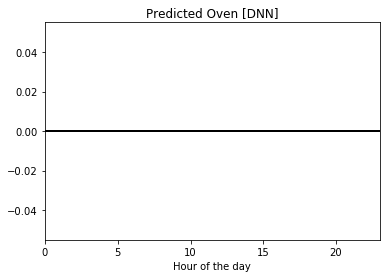

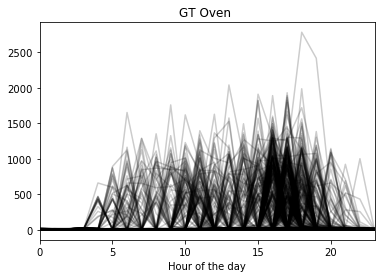

In [170]:
pd.DataFrame(pred_appliance['oven']).T.plot(legend=False, color='k',alpha=0.2)
plt.title("Predicted Oven [DNN]")
plt.xlabel("Hour of the day")
pd.DataFrame(test_appliance['oven']).T.plot(legend=False, color='k',alpha=0.2)
plt.title("GT Oven ")
plt.xlabel("Hour of the day")

In [150]:
pd.Series(test_dw[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(model.predict(test_agg[1:2])[0, :]).plot(label='Pred')




plt.legend()

NameError: name 'test_dw' is not defined

In [130]:
test_hvac.shape

(2464, 24)